# ACh Ridge Regression Analysis

This notebook demonstrates how to use the Python translation of the MATLAB ACh GLM analysis code.

## Setup

In [1]:
# Import the analysis module
from predict_ach_glm import (
    analyze_ach_single_session,
    analyze_multiple_sessions,
    plot_results
)

import numpy as np
import matplotlib.pyplot as plt

# Set up matplotlib for inline plotting
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

/opt/anaconda3/envs/neuromodulation-models/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Single Session Analysis

### Load and analyze one session

Loading data from /Volumes/Extreme SSD/ACh_paper_data/ACh_NE_042021/Data/ach3.5-2_051221_00001_N&B.mat...
Data shape: 2999 samples
Deconvolving ACh signal...
Samples above threshold: 2837 (94.6%)
Building design matrix...
Design matrix shape: (2837, 64)
Features: 64

Performing cross-validation for lambda selection...
Best lambda: 100.000

Fitting final ridge model...
Variance explained: 49.93%

Variance explained by each predictor group:
  Speed: 34.64%
  Position: 0.65%
  Reward: 0.01%
  Licking: 4.98%


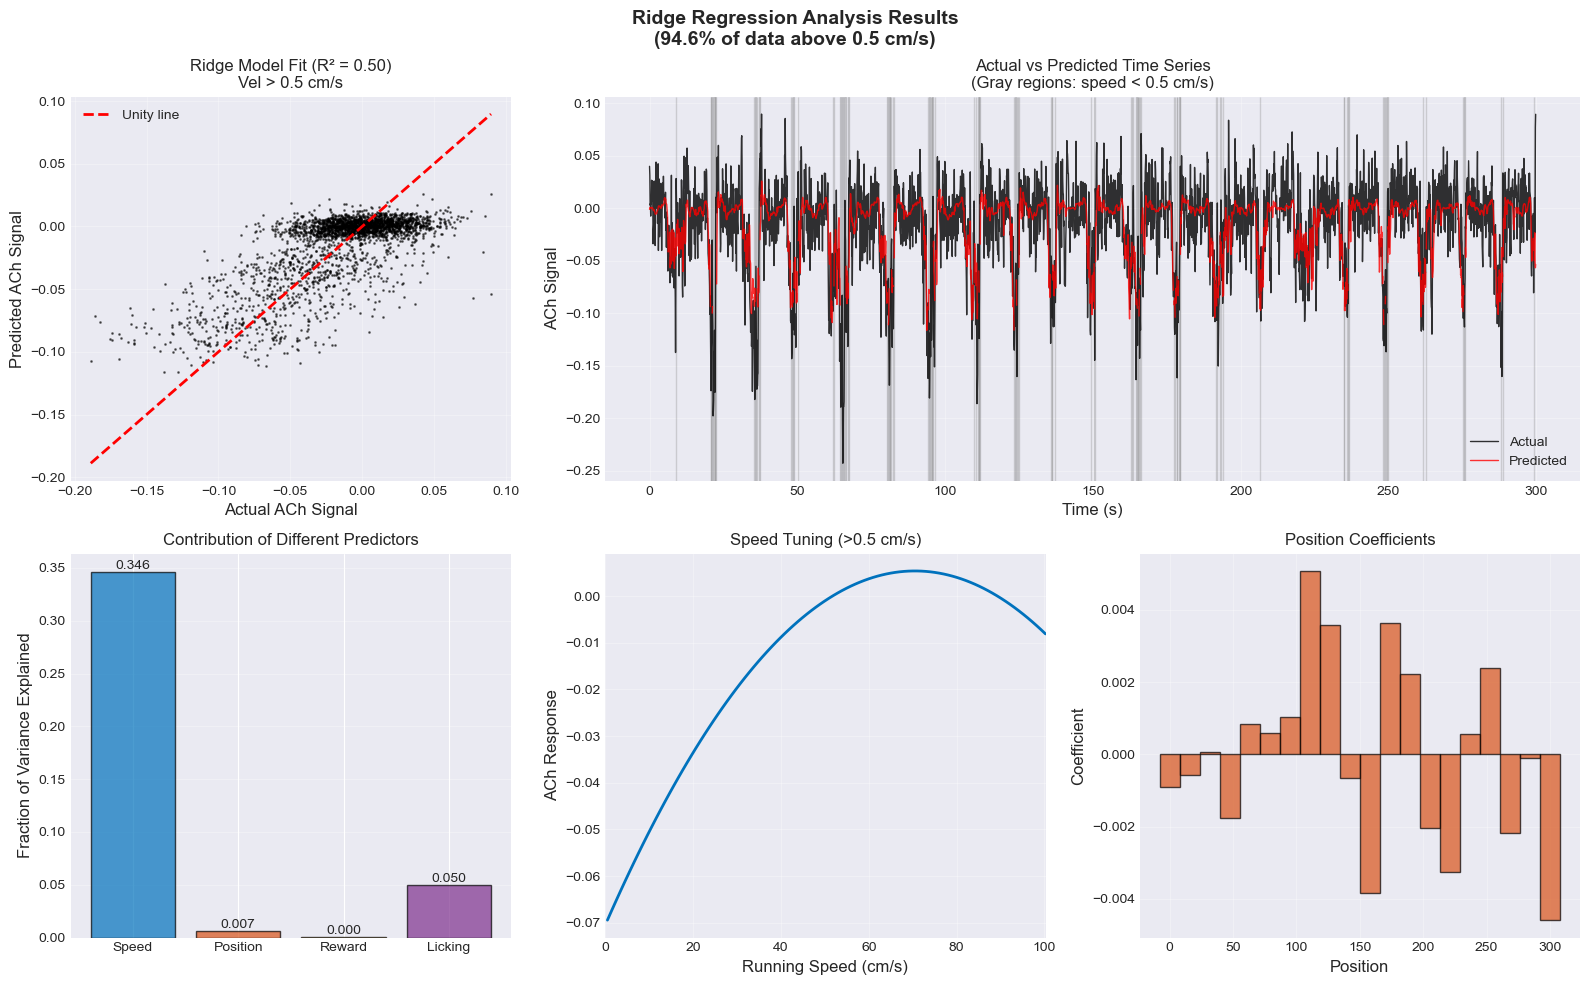

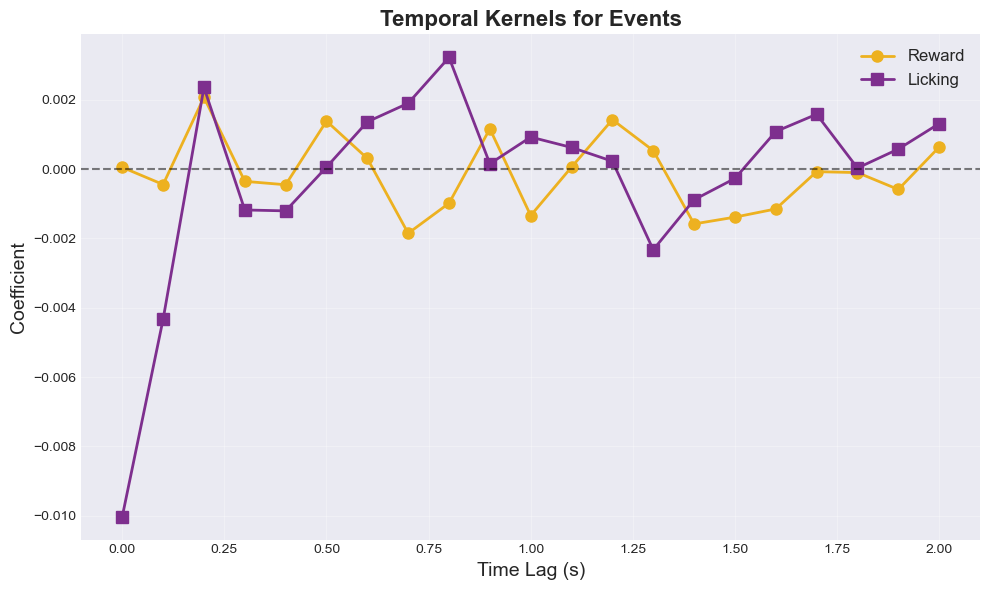

In [2]:
# Specify your .mat file path
mat_file_path = '/Volumes/Extreme SSD/ACh_paper_data/ACh_NE_042021/Data/ach3.5-2_051221_00001_N&B.mat'

# Optional: specify index range
idx_start = 1001      # or None to use all data
idx_end = 4000    # or None to use all data

# Run the analysis
results = analyze_ach_single_session(
    mat_file_path=mat_file_path,
    idx_start=idx_start,
    idx_end=idx_end,
    vel_threshold=0.5,        # cm/s
    include_position=True,    # Set to False to exclude position predictors
    dt=0.1,                   # sampling interval in seconds
    make_plots=True           # Generate visualization plots
)

### Examine the results

In [3]:
# Print summary statistics
print(f"Best lambda (regularization): {results['best_lambda']:.4f}")
print(f"Variance explained (R²): {results['var_explained']:.4f}")
print(f"Percentage of data above threshold: {100*np.mean(results['above_thresh']):.1f}%")
print("\nVariance contributions by predictor group:")
for group, variance in results['var_contributions'].items():
    print(f"  {group}: {100*variance:.2f}%")

Best lambda (regularization): 100.0000
Variance explained (R²): 0.4993
Percentage of data above threshold: 94.6%

Variance contributions by predictor group:
  Speed: 34.64%
  Position: 0.65%
  Reward: 0.01%
  Licking: 4.98%


### Access model coefficients

In [4]:
# Get the fitted model
model = results['model']

# Print intercept
print(f"Intercept: {model.intercept_:.4f}")

# Print first 10 coefficients with their feature names
print("\nFirst 10 coefficients:")
for i in range(min(10, len(results['feature_names']))):
    print(f"  {results['feature_names'][i]}: {model.coef_[i]:.4f}")

Intercept: -0.0705

First 10 coefficients:
  speed: 0.0022
  speed^2: -0.0000
  pos_bin_1: -0.0009
  pos_bin_2: -0.0006
  pos_bin_3: 0.0001
  pos_bin_4: -0.0018
  pos_bin_5: 0.0008
  pos_bin_6: 0.0006
  pos_bin_7: 0.0010
  pos_bin_8: 0.0051


### Plot specific components

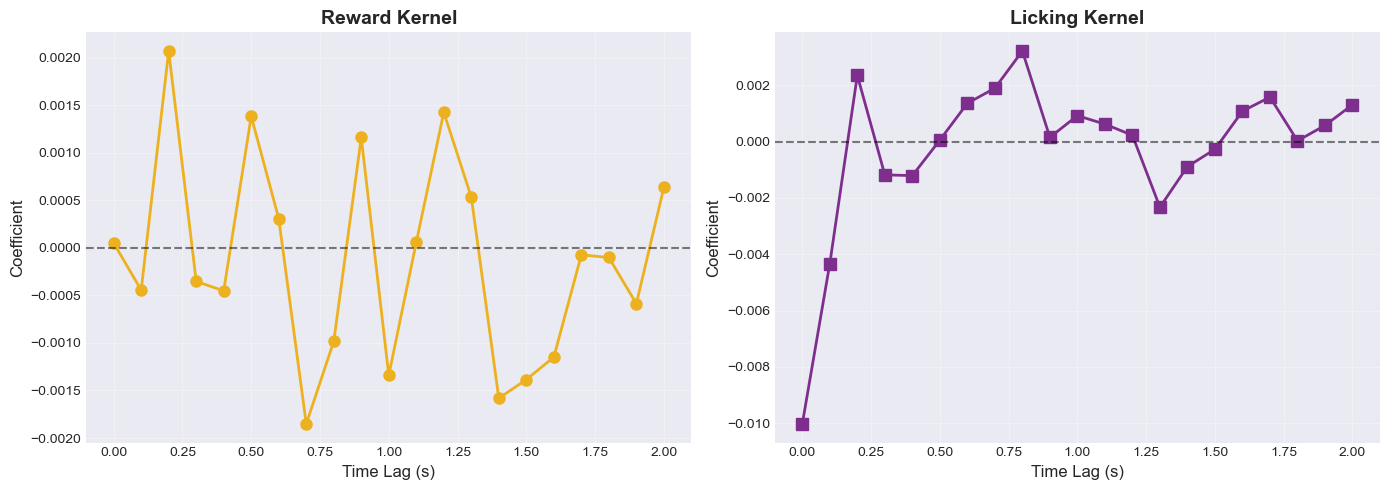

In [5]:
# Create a custom plot showing temporal kernels in detail
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Extract reward and licking coefficients
reward_coef = model.coef_[results['feature_groups']['Reward']]
licking_coef = model.coef_[results['feature_groups']['Licking']]
time_lags = np.arange(len(reward_coef)) * results['dt']

# Reward kernel
axes[0].plot(time_lags, reward_coef, 'o-', linewidth=2, markersize=8, color='#EDB120')
axes[0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Time Lag (s)', fontsize=12)
axes[0].set_ylabel('Coefficient', fontsize=12)
axes[0].set_title('Reward Kernel', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Licking kernel
axes[1].plot(time_lags, licking_coef, 's-', linewidth=2, markersize=8, color='#7E2F8E')
axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Time Lag (s)', fontsize=12)
axes[1].set_ylabel('Coefficient', fontsize=12)
axes[1].set_title('Licking Kernel', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analyze prediction quality at different time windows

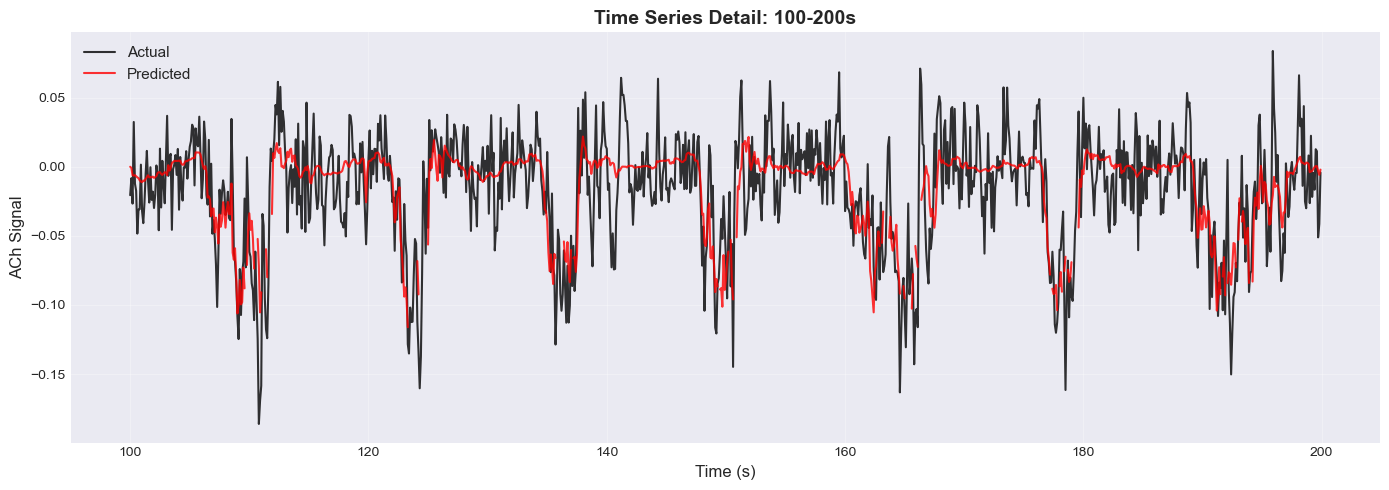

In [6]:
# Plot a zoomed-in time window
start_time = 100  # seconds
end_time = 200    # seconds

dt = results['dt']
start_idx = int(start_time / dt)
end_idx = int(end_time / dt)

t = np.arange(len(results['Y_full'])) * dt
Y_full = results['Y_full']
Y_pred_full = np.full(len(Y_full), np.nan)
Y_pred_full[results['above_thresh']] = results['Y_pred_filt']

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(t[start_idx:end_idx], Y_full[start_idx:end_idx], 
        'k', linewidth=1.5, label='Actual', alpha=0.8)
ax.plot(t[start_idx:end_idx], Y_pred_full[start_idx:end_idx], 
        'r', linewidth=1.5, label='Predicted', alpha=0.8)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('ACh Signal', fontsize=12)
ax.set_title(f'Time Series Detail: {start_time}-{end_time}s', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Multiple Session Analysis

### Analyze multiple sessions and compare results

In [ ]:
# Define your session files
session_files = [
    'path/to/session1.mat',
    'path/to/session2.mat',
    'path/to/session3.mat',
    # Add more sessions as needed
]

# Optional: define different index ranges for each session
session_idx_ranges = [
    (0, 10000),
    (500, 8000),
    (1000, 12000),
]

# Run analysis across all sessions
all_results = analyze_multiple_sessions(
    session_files=session_files,
    session_idx_ranges=session_idx_ranges,  # Set to None to use all data
    vel_threshold=0.5,
    include_position=False  # Often excluded in multi-session analysis
)

### Compare variance explained across sessions

In [ ]:
# Extract variance explained for each session
var_explained = [r['var_explained'] for r in all_results]

print("Variance explained (R²) across sessions:")
for i, ve in enumerate(var_explained, 1):
    print(f"  Session {i}: {ve:.4f}")

print(f"\nMean: {np.mean(var_explained):.4f}")
print(f"Std: {np.std(var_explained):.4f}")

### Compare temporal kernels across sessions

In [ ]:
# Plot reward kernels from all sessions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = plt.cm.viridis(np.linspace(0, 1, len(all_results)))
dt = all_results[0]['dt']

for i, results in enumerate(all_results):
    model = results['model']
    reward_coef = model.coef_[results['feature_groups']['Reward']]
    licking_coef = model.coef_[results['feature_groups']['Licking']]
    time_lags = np.arange(len(reward_coef)) * dt
    
    axes[0].plot(time_lags, reward_coef, 'o-', linewidth=2, 
                label=f'Session {i+1}', color=colors[i], alpha=0.7)
    axes[1].plot(time_lags, licking_coef, 's-', linewidth=2,
                label=f'Session {i+1}', color=colors[i], alpha=0.7)

axes[0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Time Lag (s)', fontsize=12)
axes[0].set_ylabel('Coefficient', fontsize=12)
axes[0].set_title('Reward Kernels Across Sessions', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Time Lag (s)', fontsize=12)
axes[1].set_ylabel('Coefficient', fontsize=12)
axes[1].set_title('Licking Kernels Across Sessions', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Advanced: Custom Analysis

### Build and fit your own model with custom parameters

In [ ]:
from scipy.io import loadmat
from predict_ach_glm import (
    deconvolve_grabACh_biExp,
    build_design_matrix,
    ridge_cross_validation
)
from sklearn.linear_model import Ridge

# Load your data
data = loadmat('path/to/your/data.mat')

# Extract and prepare variables
speed = np.squeeze(data['v2'])
licking = np.squeeze(data['licks2'])
reward = np.squeeze(data['reward2'])
position = np.squeeze(data['y2_norm'])
Fc = np.squeeze(data['Fc_sp'])

# Deconvolve
Fc_deconv = deconvolve_grabACh_biExp(Fc, sampling_rate=10, tau_on=0.06, tau_off=1.0)

# Apply custom filtering
vel_threshold = 1.0  # Custom threshold
above_thresh = speed > vel_threshold

# Build design matrix with custom parameters
X, feature_names = build_design_matrix(
    speed[above_thresh],
    position[above_thresh],
    licking[above_thresh],
    reward[above_thresh],
    dt=0.1,
    maxlag=30,  # Custom lag
    nbins=30    # Custom number of position bins
)

Y = Fc_deconv[above_thresh]

# Find optimal lambda
lambda_vals = np.logspace(-3, 3, 20)  # Custom lambda range
best_lambda, mean_mse = ridge_cross_validation(X, Y, lambda_vals, k=5)

print(f"Best lambda: {best_lambda:.4f}")

# Fit final model
model = Ridge(alpha=best_lambda)
model.fit(X, Y)
Y_pred = model.predict(X)

# Compute R²
r_squared = 1 - np.var(Y - Y_pred) / np.var(Y)
print(f"R² = {r_squared:.4f}")

## Tips and Notes

### Expected .mat file structure

Your .mat file should contain the following variables:
- `v2`: Running speed (cm/s)
- `licks2`: Binary licking events (0 or 1)
- `reward2`: Binary reward delivery (0 or 1)
- `y2_norm`: Normalized position on track (0 to 1)
- `Fc_sp`: Fluorescence signal (ACh sensor)

### Key parameters to adjust:

1. **`vel_threshold`**: Minimum speed for including data points (cm/s)
2. **`maxlag`**: Maximum temporal lag for event predictors (in samples)
3. **`nbins`**: Number of position bins
4. **`include_position`**: Whether to include position as a predictor
5. **`lambda_vals`**: Range of regularization parameters to test

### Performance considerations:

- Cross-validation can be slow for large datasets. Consider reducing `k` (number of folds) or the number of lambda values.
- The deconvolution step can take time for very long recordings.
- For very large datasets, you may want to downsample before analysis.
